In [5]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding='same')
        self.conv2 = nn.Conv2d(64, 64, 3, padding='same')
        self.conv3 = nn.Conv2d(64, 64, 3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16384, 128)
        self.fc2 = nn.Linear(128, 17)
        self.dropout = nn.Dropout(0.5)
        self.dropout2d = nn.Dropout2d(0.2)
    
    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        # x = self.dropout2d(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.softmax(x, dim=1)
        # x = F.sigmoid(x)
        # out1, out2 = torch.split(x, 34, dim=1)
        # out1 = torch.softmax(out1, dim=1)
        # out2 = torch.softmax(out2, dim=1)
        # x = torch.cat((out1, out2), dim=1)
        return x


In [7]:
model = Net()
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [9]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.fc1.register_forward_hook(get_activation('fc1'))
model.eval()

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=17, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (dropout2d): Dropout2d(p=0.2, inplace=False)
)

In [13]:
songs_df = pd.read_json("../NCSDownload/songs_linked.json")
songs_df = songs_df[~songs_df["genre"].isin(["N/A", ""])].dropna()
songs_df["genre"] = songs_df["genre"].apply(lambda x: [s.strip() for s in x.split(",")])
songs_df.reset_index(inplace=True, drop=True) 

genre_onehot = pd.get_dummies(songs_df["genre"].explode()).groupby(level=0).sum()

X = []
labels = []
Xmean = np.load("Xmean.npy")
Xstd = np.load("Xstd.npy")

samples = 512
step = 512
for index, row in tqdm.tqdm(songs_df.iterrows(), total=len(songs_df)):
    basename = os.path.basename(row["file"])
    file_only = os.path.splitext(basename)[0]
    path = "specgrams/" + file_only + ".png"
    if os.path.isfile(path):
        img = read_image(path, ImageReadMode.GRAY)
        if img.shape[2] < samples:
            continue
        img = (img.float() / 255.0) * 2 - 1
        img = img.unfold(2, samples, step).moveaxis(2, 0)
        img = (img - Xmean) / Xstd
        with torch.no_grad():
            preds = model(img)
            act = torch.mean(activation['fc1'], dim=0)
            X.append(act.squeeze().numpy())
            labels.append(genre_onehot.iloc[index].to_numpy())


100%|██████████| 1294/1294 [08:07<00:00,  2.66it/s]


In [16]:
X = np.array(X)
print(X.shape)

(1268, 128)


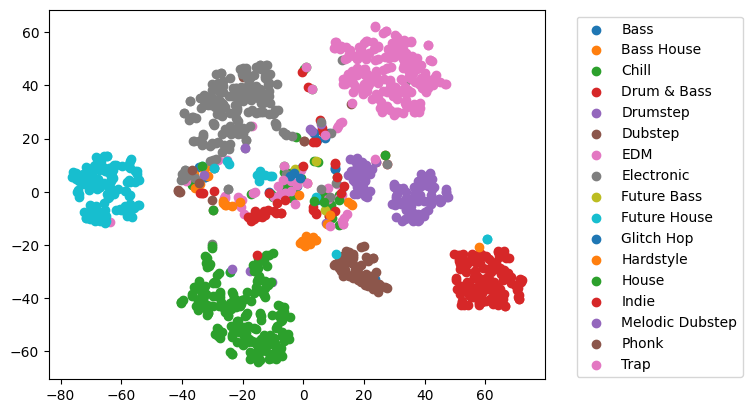

In [17]:
# X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
# X = np.load('song_vectors.npy')
# labels = np.load('song_vectors_labels.npy')
labelsI = np.argmax(labels, axis=1)
total = 0
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X)
fig, ax = plt.subplots()
genre_names = ['Bass', 'Bass House', 'Chill', 'Drum & Bass', 'Drumstep', 'Dubstep', 'EDM', 'Electronic', 'Future Bass', 'Future House', 'Glitch Hop', 'Hardstyle', 'House', 'Indie', 'Melodic Dubstep', 'Phonk', 'Trap']
for i in range(17):
    class_points = X_embedded[np.where(labelsI == i)]
    plt.scatter(class_points[:, 0], class_points[:, 1], label=genre_names[i])
ax.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
